# Siamese Model

## Upload the Data

### Import supporting libraries

In [1]:
import LoadData
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

### Connecting to the Database

In [2]:
DBLoc = "./data/benchmark.db"
conn = LoadData.connectToDB(DBLoc)

Connecting to ./data/benchmark.db .....
Connected to ./data/benchmark.db


### Open the Dataset and Dataloader

In [3]:
data = LoadData.LoadAllEncodings(conn)
data['Encoding1'] = data['Encoding1'].apply(LoadData.deserialize_encoding)
data['Encoding2'] = data['Encoding2'].apply(LoadData.deserialize_encoding)
data.head(10)

,Encoding1,Encoding2,AlignmentScore
0,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[2.057203, -0.320799, -1.235001, 2.8408, -0.77...",0.0
1,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[0.219529, 1.371923, -0.711086, 2.675397, -0.4...",0.0
2,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[-0.13575, -0.002365, 0.059046, 0.083796, 0.06...",0.0
3,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.703211, 1.607478, -1.28063, 2.984896, -1.82...",0.0
4,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.622336, 1.383203, -1.722515, 2.852858, -1.1...",0.0
5,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[0.565803, 1.289719, -0.778099, 0.875891, -0.8...",0.0
6,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[8.166027, -3.384297, -4.185069, 17.54004, -6....",0.0
7,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.068295, -0.242165, -0.632848, 1.914043, -0....",0.0
8,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[0.989081, 0.353823, -0.876116, 1.762983, -0.8...",0.0
9,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.861915, -0.115179, -0.672746, 4.931495, -1....",0.0


In [4]:
df_zero = data[(data['AlignmentScore'] == 0)]
df_one = data[(data['AlignmentScore'] == 1)]
df_non_zero = data[(data['AlignmentScore'] != 0) & (data['AlignmentScore'] != 1)]

print(f"Number of zero scores: {df_zero.shape[0]}")
print(f"Number of one scores: {df_one.shape[0]}")
print(f"Number of non-zero scores: {df_non_zero.shape[0]}")
print(f"Total number of scores: {df_zero.shape[0] + df_one.shape[0] + df_non_zero.shape[0]}")
print(f"Actual number of scores: {data.shape[0]}")

Number of zero scores: 203833
Number of one scores: 331
Number of non-zero scores: 13924
Total number of scores: 218088
Actual number of scores: 218088


### Split Data into Training, Validation and Testing Dataset
Given than we want to predict the functions with the largest alignment scores to merge, we should split it according to functions, so we can try to predict the function it is supposed to align with

In [5]:
# Evenly split the dataset so that there is an even amount of zeroes, ones and float alignment score
testing_percentage = 0.2
training_zero, testing_zero = train_test_split(df_zero, test_size=testing_percentage, random_state=42)
training_one, testing_one = train_test_split(df_one, test_size=testing_percentage, random_state=42)
training_non_zero, testing_non_zero = train_test_split(df_non_zero, test_size=testing_percentage, random_state=42)

# Split the training set into training and validation set
validation_percentage = 0.25
training_zero, validation_zero = train_test_split(training_zero, test_size=validation_percentage, random_state=42)
training_one, validation_one = train_test_split(training_one, test_size=validation_percentage, random_state=42)
training_non_zero, validation_non_zero = train_test_split(training_non_zero, test_size=validation_percentage, random_state=42)

# Ratio of zeroes to non-zero data
zero_ratio = training_zero.shape[0] / (training_non_zero.shape[0] + training_zero.shape[0] + training_one.shape[0])
print(f"Zero ratio: {zero_ratio}")
print(f"Non-zero ratio: {1 - zero_ratio}")

Zero ratio: 0.9346432201511643
Non-zero ratio: 0.0653567798488357


In [6]:
training_set = pd.concat([training_zero, training_one, training_non_zero])
validation_set = pd.concat([validation_zero, validation_one, validation_non_zero])
testing_set = pd.concat([testing_zero, testing_one, testing_non_zero])
print(f"Training Set Shape: {training_set.shape}")
print(f"Validation Set Shape: {validation_set.shape}")
print(f"Testing Set Shape: {testing_set.shape}")

# Set the sample weights for the training set
sample_weights = np.where(training_set['AlignmentScore'] == 0, 1 - zero_ratio, zero_ratio)

Training Set Shape: (130851, 3)
Validation Set Shape: (43618, 3)
Testing Set Shape: (43619, 3)


### Convert the Pandas Dataframe into NDArray

In [55]:
# Converts it into this and that
def ConvertSeriesToNDArray(series):
    NDArray = np.stack(series.to_numpy())
    return NDArray

In [49]:
training_set_copy = training_set.copy()
validation_set_copy = validation_set.copy()
testing_set_copy = testing_set.copy()

In [50]:
# Training Set
Encoding1_Train = ConvertSeriesToNDArray(training_set_copy["Encoding1"])
Encoding2_Train = ConvertSeriesToNDArray(training_set_copy["Encoding2"])
AlignmentScore_Train = training_set_copy["AlignmentScore"].to_numpy(dtype=float)

# Validation Set
Encoding1_Val = ConvertSeriesToNDArray(validation_set_copy["Encoding1"])
Encoding2_Val = ConvertSeriesToNDArray(validation_set_copy["Encoding2"])
AlignmentScore_Val = validation_set_copy["AlignmentScore"].to_numpy(dtype=float)

# Testing Set
Encoding1_Test = ConvertSeriesToNDArray(testing_set_copy["Encoding1"])
Encoding2_Test = ConvertSeriesToNDArray(testing_set_copy["Encoding2"])
AlignmentScore_Test = testing_set_copy["AlignmentScore"].to_numpy(dtype=float)

## Data Visualisation

In [76]:
import matplotlib.pyplot as plt

# Plots the data in a 3-dimensional space
# Data is a pandas dataframe with Encoding1, Encoding2, AlignmentScore columns
def PlotDataVisualisation(data):
    # Convert each pandas series into a NDArray
    Encoding1 = ConvertSeriesToNDArray(data["Encoding1"])
    Encoding2 = ConvertSeriesToNDArray(data["Encoding2"])

    # ===== TSNE =====
    from sklearn.manifold import TSNE

    # Assuming `data` is your 300-dimensional data
    tsne = TSNE(n_components=3)
    embeddings_1 = tsne.fit_transform(Encoding1)
    embeddings_2 = tsne.fit_transform(Encoding2)

    # ===== PCA =====
    # from sklearn.decomposition import PCA

    # pca = PCA(n_components=3)
    # embeddings_1 = pca.fit_transform(Encoding1)
    # embeddings_2 = pca.fit_transform(Encoding2)


    print(f"Encoding Shape: {Encoding1.shape}")
    print(f"Encoding1 Shape: {embeddings_1.shape}")
    print(f"Encoding2 Shape: {embeddings_2.shape}")

    # Plot the data
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings_1[:, 0], embeddings_1[:, 1], embeddings_1[:, 2], c='r', label='Encoding1')
    ax.scatter(embeddings_2[:, 0], embeddings_2[:, 1], embeddings_2[:, 2], c='b', label='Encoding2')
    ax.set_title('3D PCA of 300-Dimensional Embeddings')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()


### Zero Alignment Score

Encoding Shape: (203833, 300)
Encoding1 Shape: (203833, 3)
Encoding2 Shape: (203833, 3)


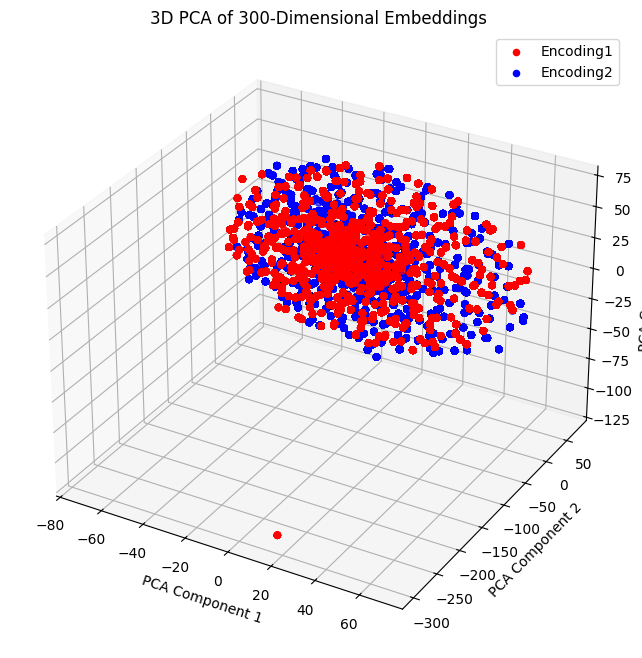

,Encoding1,Encoding2,AlignmentScore
0,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[2.057203, -0.320799, -1.235001, 2.8408, -0.77...",0.0
1,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[0.219529, 1.371923, -0.711086, 2.675397, -0.4...",0.0
2,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[-0.13575, -0.002365, 0.059046, 0.083796, 0.06...",0.0
3,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.703211, 1.607478, -1.28063, 2.984896, -1.82...",0.0
4,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.622336, 1.383203, -1.722515, 2.852858, -1.1...",0.0
5,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[0.565803, 1.289719, -0.778099, 0.875891, -0.8...",0.0
6,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[8.166027, -3.384297, -4.185069, 17.54004, -6....",0.0
7,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.068295, -0.242165, -0.632848, 1.914043, -0....",0.0
8,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[0.989081, 0.353823, -0.876116, 1.762983, -0.8...",0.0
9,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.861915, -0.115179, -0.672746, 4.931495, -1....",0.0


In [77]:
PlotDataVisualisation(df_zero)
df_zero.head(10)

### One Alignment Score

Encoding Shape: (331, 300)
Encoding1 Shape: (331, 3)
Encoding2 Shape: (331, 3)


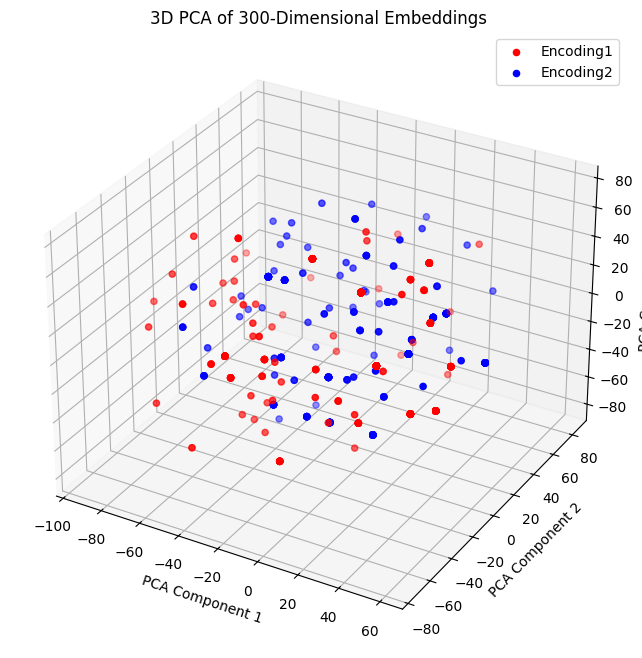

,Encoding1,Encoding2,AlignmentScore
10918,"[-0.254957, 0.066909, 0.015976, 0.031063, -0.0...","[-0.248537, 0.067381, 0.044516, 0.031868, -0.0...",1.0
15423,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.122306, -0.006545, 0.071344, 0.091632, 0.0...",1.0
15443,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...",1.0
15446,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...",1.0
15458,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.122306, -0.006545, 0.071344, 0.091632, 0.0...",1.0
15488,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.122306, -0.006545, 0.071344, 0.091632, 0.0...",1.0
15522,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...",1.0
15542,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...",1.0
15549,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.122306, -0.006545, 0.071344, 0.091632, 0.0...",1.0
15581,"[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...","[-0.116711, -0.004992, 0.094466, 0.08367, 0.09...",1.0


In [78]:
PlotDataVisualisation(df_one)
df_one.head(10)

### Non-Zero Alignment Score

Encoding Shape: (13924, 300)
Encoding1 Shape: (13924, 3)
Encoding2 Shape: (13924, 3)


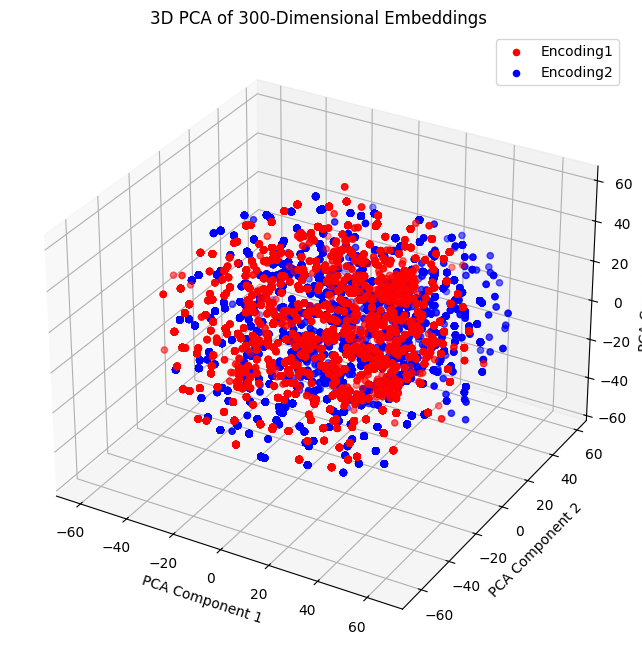

,Encoding1,Encoding2,AlignmentScore
14,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[1.982165, 1.741281, -2.433287, 4.692599, -1.8...",0.025000
15,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[14.274875, 1.589906, -10.359702, 28.570966, -...",0.011574
16,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[4.03483, -0.539064, -1.436328, 9.163819, -1.7...",0.016043
19,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[4.103456, -1.538683, -2.281239, 7.289827, -2....",0.008621
22,"[5.889621, 1.421312, -1.784085, 8.756901, -2.4...","[8.413592, 3.383597, -6.509026, 13.481208, -4....",0.012552
42,"[2.057203, -0.320799, -1.235001, 2.8408, -0.77...","[2.769465, 1.583151, -2.302617, 4.023078, -1.8...",0.027972
43,"[2.057203, -0.320799, -1.235001, 2.8408, -0.77...","[0.219529, 1.371923, -0.711086, 2.675397, -0.4...",0.022989
44,"[2.057203, -0.320799, -1.235001, 2.8408, -0.77...","[-0.13575, -0.002365, 0.059046, 0.083796, 0.06...",0.031250
46,"[2.057203, -0.320799, -1.235001, 2.8408, -0.77...","[1.622336, 1.383203, -1.722515, 2.852858, -1.1...",0.018519
47,"[2.057203, -0.320799, -1.235001, 2.8408, -0.77...","[0.565803, 1.289719, -0.778099, 0.875891, -0.8...",0.083333


In [79]:
PlotDataVisualisation(df_non_zero)
df_non_zero.head(10)

## Siamese Model

### Tensorflow

In [31]:
import tensorflow as tf
import numpy as np

In [32]:
# Check if tensorflow is using GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
    print(f"GPU: {tf.config.list_physical_devices('GPU')}")
else:
    print("TensorFlow is not using GPU")

TensorFlow is not using GPU


#### Train Model

In [35]:
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Define the base network for feature extraction
def create_base_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    # outputs = Dense(64, activation='sigmoid')(x)  # Feature vector
    outputs = Dropout(0.25)(x)
    return Model(inputs, outputs)

In [43]:
# Define input shape
input_shape = (300,)

# Create the base network
base_network = create_base_network(input_shape)

# Siamese network inputs
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Generate embeddings
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# Compute L1 distance
def l1_distance(vectors):
    x, y = vectors
    return K.abs(x - y)

distance = Lambda(l1_distance)([embedding_a, embedding_b])

# Output layer for similarity score (0 to 1 range)
output = Dense(1, activation='sigmoid')(distance)

# Define the Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
siamese_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Model summary
siamese_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 128)       │    109,952 │ input_layer_10[0… │
│ (Functional)        │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128)       │          0 │ functional_6[0][… │
│                     │                   │            │ functional_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │        129 │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,081 (430.00 KB)

 Trainable params: 110,081 (430.00 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# print(f"Encoding1 shape: {Encoding1.shape}")
# print(f"Encoding2 shape: {Encoding2.shape}")
# print(f"AlignmentScore shape: {AlignmentScore.shape}")

history = siamese_model.fit([Encoding1_Train, Encoding2_Train], AlignmentScore_Train, sample_weight=sample_weights,batch_size=32, epochs=10, validation_data=([Encoding1_Val, Encoding2_Val], AlignmentScore_Val))


Epoch 1/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0023 - mse: 0.0045 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0020 - mse: 0.0026 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 3/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0021 - mse: 0.0027 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 4/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0021 - mse: 0.0023 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0022 - mse: 0.0024 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022 - mse: 0.0023 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022 - mse: 0.0023 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/10
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0021 - mse: 0.0023 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 9/10
4090/4090 ━━━━━━━━━━━━━━━━━━━

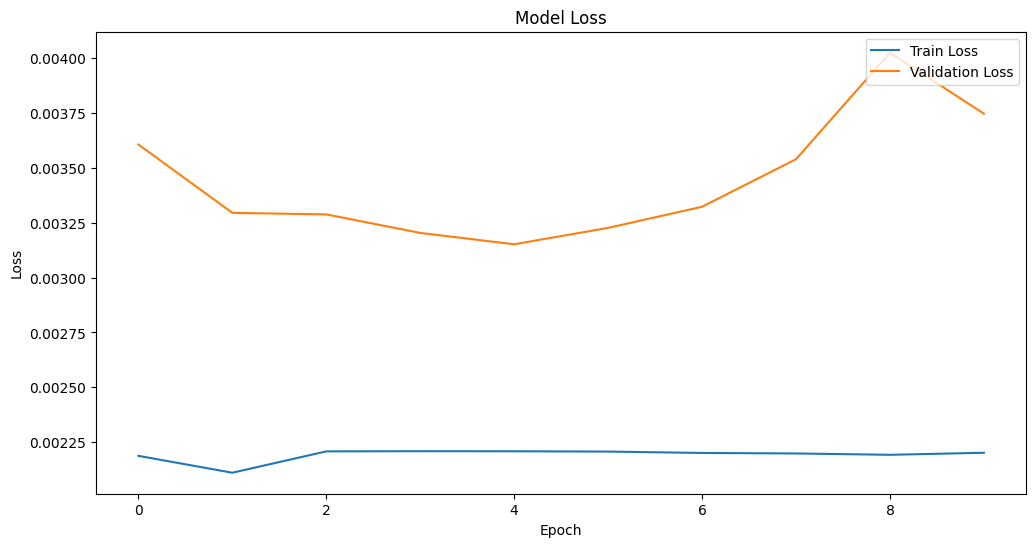

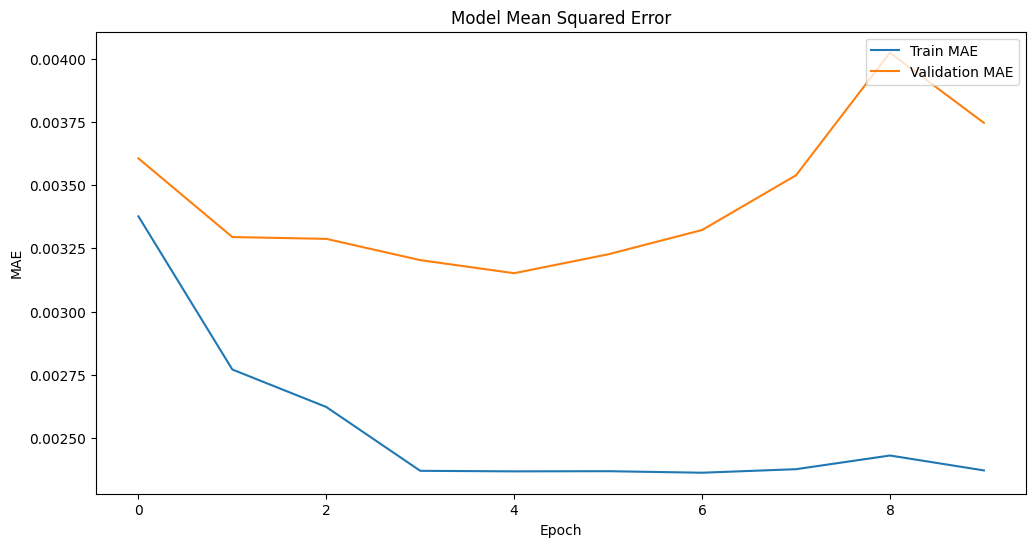

In [48]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mse'], label='Train MAE')
plt.plot(history.history['val_mse'], label='Validation MAE')
plt.title('Model Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()
# history.history

In [39]:
siamese_model.save("./data/siamese_model.keras")

#### Testing the difference

In [40]:
# import tensorflow as tf
# siamese_model = tf.keras.models.load_model("./data/siamese_model.keras")

# Make predictions on the testing set
predictions = siamese_model.predict([Encoding1_Test, Encoding2_Test])

# Print the predictions
print(predictions.shape)
print(AlignmentScore_Test.shape)

1364/1364 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step
(43619, 1)
(43619,)


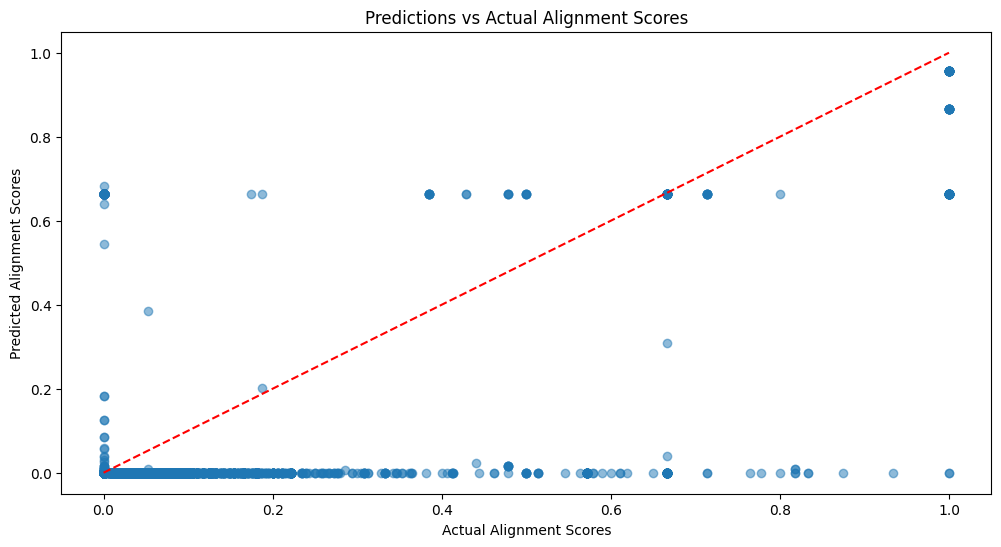

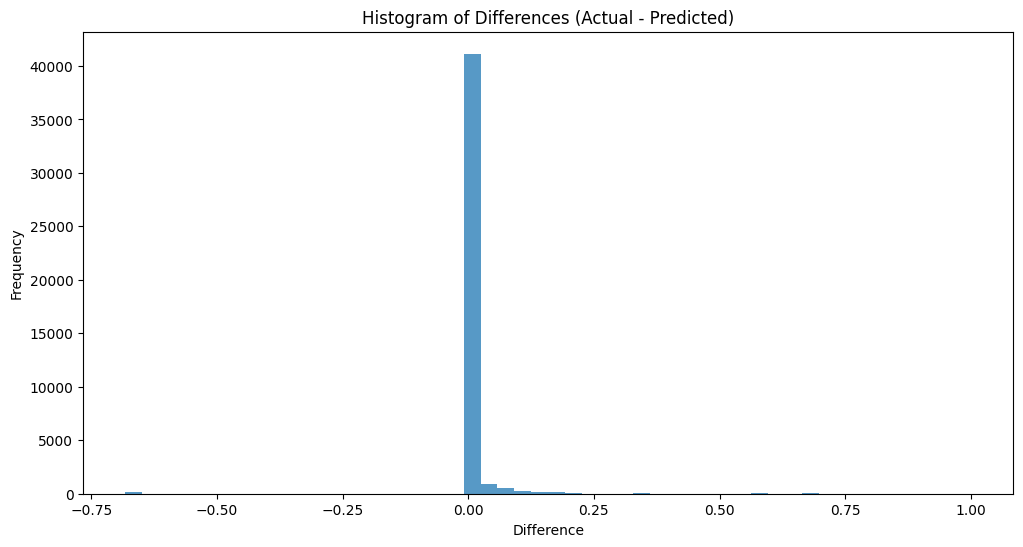

In [41]:
import matplotlib.pyplot as plt

# Scatter plot of predictions vs actual alignment scores
plt.figure(figsize=(12, 6))
plt.scatter(AlignmentScore_Test, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # Line for reference
plt.title('Predictions vs Actual Alignment Scores')
plt.xlabel('Actual Alignment Scores')
plt.ylabel('Predicted Alignment Scores')
plt.show()

# Histogram of the differences
differences = AlignmentScore_Test - predictions.flatten()
plt.figure(figsize=(12, 6))
plt.hist(differences, bins=50, alpha=0.75)
plt.title('Histogram of Differences (Actual - Predicted)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

#### Evaluate the Model using Tensorflow

In [42]:
# Evaluate the model on the testing set
evaluation = siamese_model.evaluate([Encoding1_Test, Encoding2_Test], AlignmentScore_Test)

# Print the evaluation results
print(f"Test Loss: {evaluation[0]}")
print(f"Test MAE: {evaluation[1]}")

1364/1364 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 0.0012 - mae: 0.0019
Test Loss: 0.003021729877218604
Test MAE: 0.008578919805586338


#### Custom Testing Function

In [ ]:
# Get the functions which has the highest alignment score
def GetBestMatchedFunction(df):
    pass

def EvaluateByClassification(df, predictions):
    # Find the function with the highest matc
    pass